## 16.2 Dropout Regularization in Keras

In [1]:
# Baseline Model on the Sonar Dataset
import numpy
import pandas
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.wrappers.scikit_learn import KerasClassifier
from keras.constraints import maxnorm
from keras.optimizers import SGD
from sklearn.cross_validation import cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.cross_validation import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.grid_search import GridSearchCV
from sklearn.pipeline import Pipeline

# load dataset
dataframe = pandas.read_csv("data/sonar.csv", header=None)
dataset = dataframe.values
# split into input (X) and output (Y) variables
X = dataset[:,0:60].astype(float)
Y = dataset[:,60]
# encode class values as integers
encoder = LabelEncoder()
encoder.fit(Y)
encoded_Y = encoder.transform(Y)
# baseline
def create_baseline():
  # create model
  model = Sequential()
  model.add(Dense(60, input_dim=60, init='normal', activation='relu'))
  model.add(Dense(30, init='normal', activation='relu'))
  model.add(Dense(1, init='normal', activation='sigmoid'))
  # Compile model
  sgd = SGD(lr=0.01, momentum=0.8, decay=0.0, nesterov=False)
  model.compile(loss='binary_crossentropy', optimizer=sgd, metrics=['accuracy'])
  return model

Using Theano backend.
/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [2]:
# fix random seed for reproducibility
seed = 7
numpy.random.seed(seed)

# Build pipeline
estimators = []
estimators.append(('standardize', StandardScaler()))
estimators.append(('mlp', KerasClassifier(build_fn=create_baseline, nb_epoch=300, batch_size=16, verbose=0)))
pipeline = Pipeline(estimators)

# k-Fold Cross Validation
kfold = StratifiedKFold(y=encoded_Y, n_folds=10, shuffle=True, random_state=seed)
results = cross_val_score(pipeline, X, encoded_Y, cv=kfold)
print("Baseline: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

Baseline: 82.68% (3.90%)


## 16.3 Using Dropout on the Visible Layer

In [3]:
# dropout in the input layer with weight constraint
def create_model():
    # create model
    model = Sequential()
    model.add(Dropout(0.2, input_shape=(60,)))
    model.add(Dense(60, init='normal', activation='relu', W_constraint=maxnorm(3)))
    model.add(Dense(30, init='normal', activation='relu', W_constraint=maxnorm(3)))
    model.add(Dense(1, init='normal', activation='sigmoid'))
    
    # compile model
    sgd = SGD(lr=0.1, momentum=0.9, decay=0.0, nesterov=False)
    model.compile(loss='binary_crossentropy', optimizer=sgd, metrics=['accuracy'])

    return model

In [4]:
numpy.random.seed(seed)
# Build pipeline
estimators = []
estimators.append(('standardize', StandardScaler()))
estimators.append(('mlp', KerasClassifier(build_fn=create_model, nb_epoch=300, batch_size=16, verbose=0)))
pipeline = Pipeline(estimators)

# k-Fold Cross Validation
kfold = StratifiedKFold(y=encoded_Y, n_folds=10, shuffle=True, random_state=seed)
results = cross_val_score(pipeline, X, encoded_Y, cv=kfold)
print("Baseline: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

Baseline: 86.04% (5.04%)


## 16.4 Using Dropout on Hidden Layers

In [5]:
# dropout in the hidden layer with weight constraint
def create_model():
    # create model
    model = Sequential()
    model.add(Dense(60, input_dim=60, init='normal', activation='relu', W_constraint=maxnorm(3)))
    model.add(Dropout(0.2))
    model.add(Dense(30, init='normal', activation='relu', W_constraint=maxnorm(3)))
    model.add(Dropout(0.2))
    model.add(Dense(1, init='normal', activation='sigmoid'))
    
    # compile model
    sgd = SGD(lr=0.1, momentum=0.9, decay=0.0, nesterov=False)
    model.compile(loss='binary_crossentropy', optimizer=sgd, metrics=['accuracy'])

    return model

In [6]:
numpy.random.seed(seed)
# Build pipeline
estimators = []
estimators.append(('standardize', StandardScaler()))
estimators.append(('mlp', KerasClassifier(build_fn=create_model, nb_epoch=300, batch_size=16, verbose=0)))
pipeline = Pipeline(estimators)

# k-Fold Cross Validation
kfold = StratifiedKFold(y=encoded_Y, n_folds=10, shuffle=True, random_state=seed)
results = cross_val_score(pipeline, X, encoded_Y, cv=kfold)
print("Baseline: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

Baseline: 83.11% (4.55%)


In [17]:
# dropout in the hidden layer with weight constraint
def create_model():
    # create model
    model = Sequential()
    model.add(Dense(60, input_dim=60, init='normal', activation='relu', W_constraint=maxnorm(5)))
    model.add(Dropout(0.2))
    model.add(Dense(30, init='normal', activation='relu', W_constraint=maxnorm(5)))
    model.add(Dropout(0.2))
    model.add(Dense(1, init='normal', activation='sigmoid'))
    
    # compile model
    sgd = SGD(lr=0.1, momentum=0.9, decay=0.0, nesterov=False)
    model.compile(loss='binary_crossentropy', optimizer=sgd, metrics=['accuracy'])

    return model

In [18]:
model_1 = create_model()
# Fit the model
history = model_1.fit(X, encoded_Y, validation_split=0.10, nb_epoch=300, batch_size=20, verbose=0)

In [19]:
# list all data in history
print(history.history.keys())

['acc', 'loss', 'val_acc', 'val_loss']


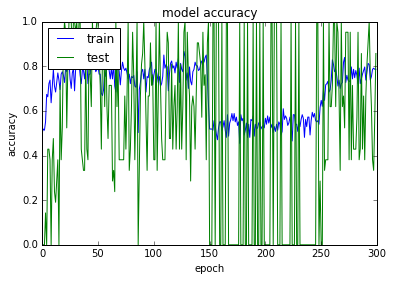

In [20]:
import matplotlib.pyplot as plt
%matplotlib inline
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

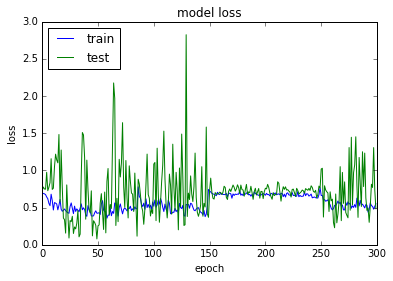

In [21]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

## 17.3 Time-Based Learning Rate Schedule

In [22]:
# Time Based Learning Rate Decay
import pandas
import numpy
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import SGD
from sklearn.preprocessing import LabelEncoder
# fix random seed for reproducibility
seed = 7
numpy.random.seed(seed)
# load dataset
dataframe = pandas.read_csv("data/ionosphere.csv", header=None)
dataset = dataframe.values
# split into input (X) and output (Y) variables
X = dataset[:,0:34].astype(float)
Y = dataset[:,34]
# encode class values as integers
encoder = LabelEncoder()
encoder.fit(Y)
Y = encoder.transform(Y)
# create model
model = Sequential()
model.add(Dense(34, input_dim=34, init='normal', activation='relu'))
model.add(Dense(1, init='normal', activation='sigmoid'))
# Compile model
epochs = 50
learning_rate = 0.1
decay_rate = learning_rate / epochs
momentum = 0.8
sgd = SGD(lr=learning_rate, momentum=momentum, decay=decay_rate, nesterov=False)
model.compile(loss='binary_crossentropy', optimizer=sgd, metrics=['accuracy'])
# Fit the model
model.fit(X, Y, validation_split=0.33, nb_epoch=epochs, batch_size=28, verbose=2)

Train on 235 samples, validate on 116 samples
Epoch 1/50
0s - loss: 0.6756 - acc: 0.7277 - val_loss: 0.6029 - val_acc: 0.8621
Epoch 2/50
0s - loss: 0.6179 - acc: 0.7787 - val_loss: 0.4956 - val_acc: 0.8793
Epoch 3/50
0s - loss: 0.5326 - acc: 0.8170 - val_loss: 0.4504 - val_acc: 0.9483
Epoch 4/50
0s - loss: 0.4405 - acc: 0.8298 - val_loss: 0.4003 - val_acc: 0.9397
Epoch 5/50
0s - loss: 0.3678 - acc: 0.8681 - val_loss: 0.4080 - val_acc: 0.8793
Epoch 6/50
0s - loss: 0.3104 - acc: 0.8979 - val_loss: 0.2980 - val_acc: 0.9397
Epoch 7/50
0s - loss: 0.2732 - acc: 0.9234 - val_loss: 0.1971 - val_acc: 0.9569
Epoch 8/50
0s - loss: 0.2313 - acc: 0.9106 - val_loss: 0.2190 - val_acc: 0.9397
Epoch 9/50
0s - loss: 0.2148 - acc: 0.9191 - val_loss: 0.1976 - val_acc: 0.9483
Epoch 10/50
0s - loss: 0.1930 - acc: 0.9319 - val_loss: 0.2361 - val_acc: 0.9138
Epoch 11/50
0s - loss: 0.2077 - acc: 0.9319 - val_loss: 0.1159 - val_acc: 0.9741
Epoch 12/50
0s - loss: 0.1728 - acc: 0.9447 - val_loss: 0.1710 - val_acc

## 17.4 Drop-Based Learning Rate Schedule

In [61]:
from keras.callbacks import LearningRateScheduler
import math

# learning rate schedule
def step_decay(epoch):
    initial_lrate = 0.1
    drop = 0.5
    epochs_drop = 10.0
    lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
    
    return lrate

In [62]:
# fix random seed for reproducibility
seed = 7
numpy.random.seed(seed)
# create model
model = Sequential()
model.add(Dense(34, input_dim=34, init='normal', activation='relu'))
model.add(Dense(1, init='normal', activation='sigmoid'))
# Compile model
sgd = SGD(lr=0.0, momentum=0.9, decay=0.0, nesterov=False)
model.compile(loss='binary_crossentropy', optimizer=sgd, metrics=['accuracy'])

In [63]:
# learning schedule callback
lrate = LearningRateScheduler(step_decay)
callbacks_list = [lrate]
# Fit the model
model.fit(X, Y, validation_split=0.33, nb_epoch=60, batch_size=28, callbacks=callbacks_list, verbose=1)

Train on 235 samples, validate on 116 samples
Epoch 1/60
235/235 [==============================] - 0s - loss: 0.6742 - acc: 0.7277 - val_loss: 0.5805 - val_acc: 0.8707
Epoch 2/60
235/235 [==============================] - 0s - loss: 0.5959 - acc: 0.7745 - val_loss: 0.4430 - val_acc: 0.8879
Epoch 3/60
235/235 [==============================] - 0s - loss: 0.4660 - acc: 0.8043 - val_loss: 0.3540 - val_acc: 0.9397
Epoch 4/60
235/235 [==============================] - 0s - loss: 0.3386 - acc: 0.8766 - val_loss: 0.3263 - val_acc: 0.8879
Epoch 5/60
235/235 [==============================] - 0s - loss: 0.2724 - acc: 0.8851 - val_loss: 0.3341 - val_acc: 0.8879
Epoch 6/60
235/235 [==============================] - 0s - loss: 0.2235 - acc: 0.9191 - val_loss: 0.2656 - val_acc: 0.8966
Epoch 7/60
235/235 [==============================] - 0s - loss: 0.1990 - acc: 0.9362 - val_loss: 0.1792 - val_acc: 0.9741
Epoch 8/60
235/235 [==============================] - 0s - loss: 0.1568 - acc: 0.9532 - val_l

### Respone to Accuracy

In [70]:
# fix random seed for reproducibility
seed = 7
numpy.random.seed(seed)
# create model
model = Sequential()
model.add(Dense(34, input_dim=34, init='normal', activation='relu'))
model.add(Dense(1, init='normal', activation='sigmoid'))
# Compile model
sgd = SGD(lr=0.0, momentum=0.9, decay=0.0, nesterov=False)
model.compile(loss='binary_crossentropy', optimizer=sgd, metrics=['accuracy'])

In [71]:
#from keras.callbacks import ReduceLROnPlateau

# Reduce learning_rate as val_loss pleateu
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                  patience=5, min_lr=0.001)
callbacks_list = [reduce_lr]
# Fit the model
model.fit(X, Y, validation_split=0.33, nb_epoch=60, batch_size=28, callbacks=callbacks_list, verbose=1)

TypeError: __init__() got an unexpected keyword argument 'factor'

In [69]:
class Callback(object):
    '''Abstract base class used to build new callbacks.
    # Properties
        params: dict. Training parameters
            (eg. verbosity, batch size, number of epochs...).
        model: instance of `keras.models.Model`.
            Reference of the model being trained.
    The `logs` dictionary that callback methods
    take as argument will contain keys for quantities relevant to
    the current batch or epoch.
    Currently, the `.fit()` method of the `Sequential` model class
    will include the following quantities in the `logs` that
    it passes to its callbacks:
        on_epoch_end: logs include `acc` and `loss`, and
            optionally include `val_loss`
            (if validation is enabled in `fit`), and `val_acc`
            (if validation and accuracy monitoring are enabled).
        on_batch_begin: logs include `size`,
            the number of samples in the current batch.
        on_batch_end: logs include `loss`, and optionally `acc`
            (if accuracy monitoring is enabled).
    '''
    def __init__(self):
        pass

    def _set_params(self, params):
        self.params = params

    def _set_model(self, model):
        self.model = model

    def on_epoch_begin(self, epoch, logs={}):
        pass

    def on_epoch_end(self, epoch, logs={}):
        pass

    def on_batch_begin(self, batch, logs={}):
        pass

    def on_batch_end(self, batch, logs={}):
        pass

    def on_train_begin(self, logs={}):
        pass

    def on_train_end(self, logs={}):
        pass
    
class ReduceLROnPlateau(Callback):
    """
    Reduce learning rate when a metric has stopped improving.
    """

    def __init__(self, monitor='val_loss', reduce_factor=0.1, patience=0, verbose=0, mode='auto', epsilon=1e-4,
                 cooldown=0, min_lr=0):
        super(Callback, self).__init__()

        self.monitor = monitor
        self.reduce_factor = reduce_factor
        self.min_lr = min_lr
        self.epsilon = epsilon
        self.patience = patience
        self.verbose = verbose
        self.cooldown = cooldown  # Number of epochs to wait after reducing learning rate.
        self.in_cooldown = 0  # Cooldown counter.
        self.wait = 0
        self.best = 0
        self.mode = mode
        self.reset()

    def reset(self):
        if self.mode not in ['auto', 'min', 'max']:
            warnings.warn('Learning Rate Plateau Reducing mode %s is unknown, '
                          'fallback to auto mode.' % (self.mode), RuntimeWarning)
            self.mode = 'auto'
        if self.mode == 'min' or (self.mode == 'auto' and 'acc' not in self.monitor):
            self.monitor_op = lambda a, b: np.less(a, b - self.epsilon)
            self.best = np.Inf
        else:
            self.monitor_op = lambda a, b: np.greater(a, b + self.epsilon)
            self.best = -np.Inf
        self.in_cooldown = 0  # Cooldown counter.
        self.wait = 0

    def on_train_begin(self, logs={}):
        self.reset()

    def on_epoch_end(self, epoch, logs={}):
        logs['lr'] = K.get_value(self.model.optimizer.lr)
        current = logs.get(self.monitor)
        if current is None:
            warnings.warn('Learning Rate Plateau Reducing requires %s available!' %
                          (self.monitor), RuntimeWarning)
        else:
            if self.in_cooldown > 0:
                self.in_cooldown -= 1
                self.wait = 0
            elif self.monitor_op(current, self.best):
                self.best = current
                self.wait = 0
            else:
                if self.wait >= self.patience:
                    old_lr = float(K.get_value(self.model.optimizer.lr))
                    if old_lr > self.min_lr:
                        new_lr = old_lr * self.reduce_factor
                        new_lr = max(new_lr, self.min_lr)
                        K.set_value(self.model.optimizer.lr, new_lr)
                        if self.verbose > 0:
                            print('\nEpoch %05d: reducing learning rate to %s (Patience: ' % (epoch, new_lr))
                        self.in_cooldown = self.cooldown
                self.wait += 1